# Q-learning with OpenAI.Gym

## Окружение

In [16]:
import gym
import numpy as np
import matplotlib.pyplot as plt

import random
import os
from time import sleep

In [2]:
%matplotlib inline

Будем использовать окружение `MountainCar`.

In [3]:
env = gym.make("MountainCar-v0")

In [4]:
env.observation_space

Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)

In [5]:
env.action_space

Discrete(3)

Попробуем запустить и посмотреть на простой стратегии.

In [6]:
score = 0
state = env.reset()
for n in range(200):
    if n < 75:
        action = 0
    elif n < 150:
        action = 2
    else:
        action = 1
    env.render()
    state, reward, done, _ = env.step(action)
    score += reward
    sleep(0.05)
    print(state, reward, done, score)
env.close()

[-0.52719691 -0.00098037] -1.0 False -1.0
[-0.52915029 -0.00195338] -1.0 False -2.0
[-0.53206204 -0.00291175] -1.0 False -3.0
[-0.53591032 -0.00384828] -1.0 False -4.0
[-0.54066628 -0.00475596] -1.0 False -5.0
[-0.54629429 -0.00562801] -1.0 False -6.0
[-0.55275222 -0.00645793] -1.0 False -7.0
[-0.55999178 -0.00723956] -1.0 False -8.0
[-0.56795893 -0.00796715] -1.0 False -9.0
[-0.57659436 -0.00863543] -1.0 False -10.0
[-0.585834   -0.00923964] -1.0 False -11.0
[-0.59560958 -0.00977558] -1.0 False -12.0
[-0.60584926 -0.01023969] -1.0 False -13.0
[-0.61647832 -0.01062905] -1.0 False -14.0
[-0.62741975 -0.01094143] -1.0 False -15.0
[-0.63859506 -0.01117531] -1.0 False -16.0
[-0.6499249  -0.01132984] -1.0 False -17.0
[-0.66132981 -0.01140491] -1.0 False -18.0
[-0.67273088 -0.01140107] -1.0 False -19.0
[-0.6840504  -0.01131952] -1.0 False -20.0
[-0.69521247 -0.01116207] -1.0 False -21.0
[-0.70614355 -0.01093108] -1.0 False -22.0
[-0.71677296 -0.01062941] -1.0 False -23.0
[-0.72703331 -0.0102

[-5.17164745e-01  2.04371527e-04] -1.0 False -188.0
[-5.17008626e-01  1.56119297e-04] -1.0 False -189.0
[-5.16901930e-01  1.06696396e-04] -1.0 False -190.0
[-5.16845456e-01  5.64734313e-05] -1.0 False -191.0
[-5.16839629e-01  5.82700174e-06] -1.0 False -192.0
[-5.16884492e-01 -4.48631213e-05] -1.0 False -193.0
[-5.16979709e-01 -9.52168397e-05] -1.0 False -194.0
[-5.17124566e-01 -1.44856575e-04] -1.0 False -195.0
[-5.17317976e-01 -1.93410095e-04] -1.0 False -196.0
[-5.17558489e-01 -2.40513305e-04] -1.0 False -197.0
[-5.17844302e-01 -2.85812973e-04] -1.0 False -198.0
[-5.18173272e-01 -3.28969379e-04] -1.0 False -199.0
[-5.18542930e-01 -3.69658862e-04] -1.0 True -200.0


Размерность пространства 2: `x-координата` и `скорость`. Размерность пространства действий 3: `0`-влево, `1`-видимо ничего, `2`-вправо.

In [7]:
NA = 3
NS = 2

## Модель

In [29]:
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.activations import relu, linear
from keras.models import load_model

from collections import deque

In [32]:
class Model:
    def __init__(self, NS, NA, eps=1.0, eps_decay=0.998, gamma=0.99, batch_size=1):
        self.NS = NS
        self.NA = NA
        self.eps = eps
        self.eps_decay = eps_decay
        self.gamma = gamma
        
        self.model = self.__create_nn()
        self.batch_size = batch_size
        self.memory = deque()
    
    def __create_nn(self):    
        model = Sequential()
        model.add(Dense(64, input_dim=self.NS, activation=relu))
        model.add(Dense(64, activation=relu))
        model.add(Dense(self.NA, activation=linear))
        model.compile(loss='mse', optimizer=Adam(0.001))
        
        model.summary()
        return model
    
    def update(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states = np.squeeze([i[0] for i in batch])
        actions = np.array([i[1] for i in batch])
        rewards = np.array([i[2] for i in batch])
        next_states = np.squeeze([i[3] for i in batch])
        dones = np.array([i[4] for i in batch])

        targets = self.model.predict_on_batch(states)
        targets[np.arange(len(actions)), [actions]] = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)

        self.model.fit(states, targets, epochs=1, verbose=0)
        
        if self.eps > 0.01:
            self.eps *= self.eps_decay

    def act(self, state):
        if np.random.rand() <= self.eps:
            return random.randrange(self.NA)
        qs = self.model.predict(state)
        return np.argmax(qs[0])

    def save(self, path):
        self.model.save(path)

    def load(self, path):
        self.model = load_model(path)
        self.model.summary()



### Обучение

Немного изменим награду, уменьшая штраф времени, в зависимости от разницы между стартовой позицией и позицией вагонетки.

In [13]:
model = Model(NS, NA, batch_size=64)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 195       
Total params: 4,547
Trainable params: 4,547
Non-trainable params: 0
_________________________________________________________________


In [14]:
scores = []
max_rewards = []
for e in range(400):
    state = np.reshape(env.reset(), (1, NS))
    offset = state[0][0]
    score = 0
    max_reward = None
    for i in range(201):
        action = model.act(state)
        env.render()
        next_state, reward, done, _ = env.step(action)

        score += reward
        reward += abs(next_state[0] - offset)
        max_reward = reward if max_reward is None or reward > max_reward else max_reward

        next_state = np.reshape(next_state, (1, NS))
        model.update(state, action, reward, next_state, done)
        state = next_state

        if done:
            print(f"episode {e} step {i} => score {score}, max reward {max_reward}")
            break

    scores.append(score)
    max_rewards.append(max_reward)

    if np.mean(scores[-50:]) > -100:
        print(f"converged after {e + 1} episodes")
        break

env.close()

episode 0 step 199 => score -200.0, max reward -0.8134785088399253
episode 1 step 199 => score -200.0, max reward -0.5382439817047494
episode 2 step 199 => score -200.0, max reward -0.8735823713152282
episode 3 step 199 => score -200.0, max reward -0.688115222999202
episode 4 step 199 => score -200.0, max reward -0.8190082744443532
episode 5 step 199 => score -200.0, max reward -0.5646761010010928
episode 6 step 199 => score -200.0, max reward -0.6202347576363154
episode 7 step 187 => score -188.0, max reward -0.007713076697184795
episode 8 step 199 => score -200.0, max reward -0.31602746349431443
episode 9 step 199 => score -200.0, max reward -0.7908462045244213
episode 10 step 199 => score -200.0, max reward -0.5435025558080735
episode 11 step 199 => score -200.0, max reward -0.4043335363993029
episode 12 step 199 => score -200.0, max reward -0.7827002785820643
episode 13 step 199 => score -200.0, max reward -0.46185415565540033
episode 14 step 199 => score -200.0, max reward -0.7213

episode 120 step 172 => score -173.0, max reward 0.027309310124666863
episode 121 step 177 => score -178.0, max reward 0.009257109875870473
episode 122 step 183 => score -184.0, max reward -0.01690342620675156
episode 123 step 117 => score -118.0, max reward 0.12964670451055094
episode 124 step 156 => score -157.0, max reward 0.019115498645652984
episode 125 step 83 => score -84.0, max reward -0.08617231600041997
episode 126 step 147 => score -148.0, max reward 0.049821752405107
episode 127 step 130 => score -131.0, max reward 0.05393056077947955
episode 128 step 152 => score -153.0, max reward 0.0636222746413504
episode 129 step 128 => score -129.0, max reward 0.09496523328996331
episode 130 step 111 => score -112.0, max reward 0.042505997010247265
episode 131 step 112 => score -113.0, max reward 0.1186771883181219
episode 132 step 139 => score -140.0, max reward 0.1185922082043116
episode 133 step 147 => score -148.0, max reward 0.030663227150435457
episode 134 step 147 => score -148

episode 239 step 109 => score -110.0, max reward 0.07395168810709851
episode 240 step 117 => score -118.0, max reward 0.07237400048601139
episode 241 step 124 => score -125.0, max reward 0.06406321235458745
episode 242 step 168 => score -169.0, max reward 0.03806117861117864
episode 243 step 161 => score -162.0, max reward 0.09842124544819342
episode 244 step 196 => score -197.0, max reward -0.010432859181161325
episode 245 step 110 => score -111.0, max reward 0.11100115165257063
episode 246 step 111 => score -112.0, max reward 0.021816650503592383
episode 247 step 124 => score -125.0, max reward 0.08748066090886697
episode 248 step 107 => score -108.0, max reward 0.020916438056820308
episode 249 step 108 => score -109.0, max reward -0.00031988435472518617
episode 250 step 115 => score -116.0, max reward 0.09014990515728427
episode 251 step 128 => score -129.0, max reward 0.04529031843289055
episode 252 step 175 => score -176.0, max reward 0.039837925076732894
episode 253 step 113 => s

episode 358 step 121 => score -122.0, max reward 0.05817479395416525
episode 359 step 123 => score -124.0, max reward 0.0727987131533645
episode 360 step 103 => score -104.0, max reward -0.04718181150517731
episode 361 step 108 => score -109.0, max reward -0.03003255852126907
episode 362 step 121 => score -122.0, max reward 0.12340144452286883
episode 363 step 132 => score -133.0, max reward 0.1260722626197377
episode 364 step 152 => score -153.0, max reward 0.08215038590440304
episode 365 step 182 => score -183.0, max reward -0.021995670119706934
episode 366 step 138 => score -139.0, max reward 0.06827987504294364
episode 367 step 134 => score -135.0, max reward 0.046992390387330385
episode 368 step 112 => score -113.0, max reward 0.024523094257278277
episode 369 step 110 => score -111.0, max reward 0.05156347520338622
episode 370 step 84 => score -85.0, max reward -0.07657571724348244
episode 371 step 110 => score -111.0, max reward 0.043125126696758276
episode 372 step 103 => score 

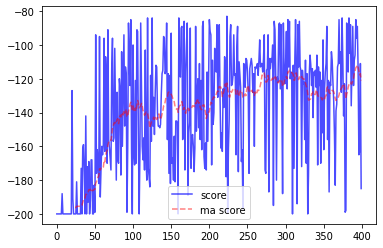

In [28]:
window = 25
ma_scores = np.convolve(scores, np.ones(window), 'valid') / window


plt.plot(np.arange(len(scores)), scores, 'b-', alpha=0.7, label='score')
plt.plot(np.arange(window - 1, len(scores)), ma_scores, 'r--', alpha=0.5, label='ma score')
_ = plt.legend()

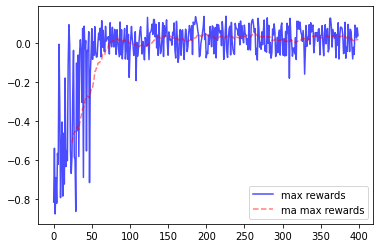

In [27]:
window = 25
ma_rewards= np.convolve(max_rewards, np.ones(window), 'valid') / window


plt.plot(np.arange(len(max_rewards)), max_rewards, 'b-', alpha=0.7, label='max rewards')
plt.plot(np.arange(window - 1, len(max_rewards)), ma_rewards, 'r--', alpha=0.5, label='ma max rewards')
_ = plt.legend()